# Summary

Fit ARHMMs to DLC labels

In [1]:
import os
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import zscore

import flygenvectors.plotting as plotting
import flygenvectors.utils as utils
import flygenvectors.data as dataUtils

In [2]:
plot_dark = False

sns.set_context('talk')
if plot_dark:
    plt.style.use('dark_background')
#     cmap_rasters = 'inferno'
    cmap_rasters = 'afmhot'
else:
    sns.set_style('white')
    cmap_rasters = 'Greys'

# 1. Load and preprocess data

In [3]:
# options
# expt_id = '190424_f3' # run+feed
# expt_id = '180824_f3r1' # run only
# expt_id = '2019_06_26_fly2'
# expt_id = '2019_06_28_fly2'
# expt_id = '2019_06_30_fly1'
expt_id = '2019_07_01_fly2'

data_dict = dataUtils.load_timeseries(expt_id)
print('Loaded data from experiment %s' % expt_id)
print('n cells: %i' % data_dict['dFF'].shape[1])
print('n time points: %i' % data_dict['dFF'].shape[0])
print('n epochs: %i' % len(np.unique(data_dict['trialFlag'])))

Loaded data from experiment 2019_07_01_fly2
n cells: 1293
n time points: 10293
n epochs: 3


### preprocess data - split into training/testing sets

In [4]:
# chose which trials to use (NoneType to default to all)
trial_flags = None #[1, 2, 3]
if trial_flags is None:
    trial_flags = np.unique(data_dict['trialFlag'])
indxs_flag = np.full(shape=(data_dict['time'].shape[0],), fill_value=False)
for trial_flag in trial_flags:
    indxs_flag |= data_dict['trialFlag'][:, 0] == trial_flag
data_neural = data_dict['dFF'][indxs_flag]
data_ball = data_dict['ball'][indxs_flag]
beh = dict(
    x=zscore(data_dict['dlc'][:, 0::3]),
    y=zscore(data_dict['dlc'][:, 1::3]),
    l=data_dict['dlc'][:, 2::3])
data_dlc = np.concatenate([beh['x'], beh['y']], axis=1)

# preprocess neural data
from scipy import signal
data_neural, A = dataUtils.remove_artifact_cells(data_neural, footprints=data_dict['A'])
data_neural = signal.detrend(data_neural, axis=0)
data_neural = zscore(data_neural)
data_neural = dataUtils.cluster(data_neural)

### check outliers

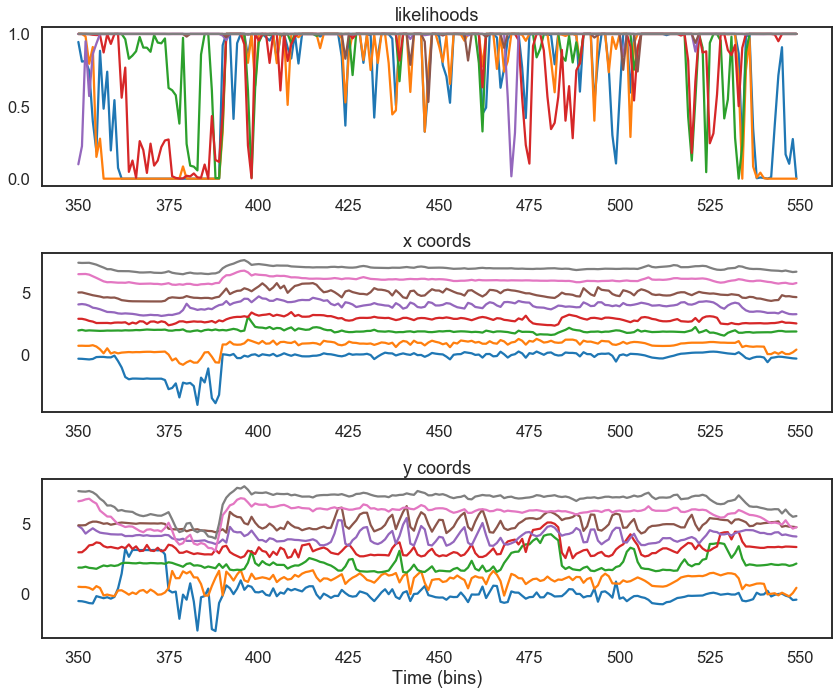

In [5]:
# plot dlc labels/likelihoods over time
slc = (350, 550)

plt.figure(figsize=(12, 10))

plt.subplot(311)
plt.plot(np.arange(slc[0], slc[1]), beh['l'][slice(*slc), :])
plt.title('likelihoods')

plt.subplot(312)
coord = 'x'
behavior = 4* beh[coord] / np.max(np.abs(beh[coord])) + np.arange(beh[coord].shape[1])
plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
plt.title('%s coords' % coord)

plt.subplot(313)
coord = 'y'
behavior = 4* beh[coord] / np.max(np.abs(beh[coord])) + np.arange(beh[coord].shape[1])
plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
plt.title('%s coords' % coord)

plt.xlabel('Time (bins)')
plt.tight_layout()
plt.show()

In [6]:
# percentage of time points below a certain threshold per label
thresh = 0.9
bad_frac = np.sum((beh['l'] < thresh) * 1.0, axis=0) / beh['l'].shape[0]
print(bad_frac)

[0.20275916 0.24744972 0.12425921 0.14145536 0.02030506 0.02195667
 0.         0.0029146 ]


In [7]:
# percentage of time points below a certain threshold for any label
thresh = 0.5
bad_frac = np.sum((np.min(beh['l'], axis=1) < thresh) * 1.0) / beh['l'].shape[0]
print(bad_frac)

0.16506363548042358


### split into train/test trials

In [8]:
# split into train/test trials
trial_len = 200  # length of pseudo-trials in bins
n_trials = np.floor(data_neural.shape[0] / trial_len)
indxs_tr = utils.split_trials(
    n_trials, trials_tr=5, trials_val=1, trials_test=0, trials_gap=0)

data = {}
dlc = {}
indxs = {}
for dtype in ['train', 'test', 'val']:
    indx_segs = []
    data_segs = []
    dlc_segs = []
    for indx in indxs_tr[dtype]:
        ibeg = indx*trial_len
        iend = indx*trial_len + trial_len
        # check to see if segment spans multiple trials; if so skip
        if len(np.unique(data_dict['trialFlag'][ibeg:iend])) == 1:
            indx_segs.append(np.arange(ibeg, iend))
            data_segs.append(data_neural[indx_segs[-1]])
            dlc_segs.append(data_dlc[indx_segs[-1]])
    indxs[dtype] = indx_segs
    data[dtype] = data_segs
    dlc[dtype] = dlc_segs
# for PCA/regression
indxs['train_all'] = np.concatenate(indxs['train'], axis=0)
indxs['val_all'] = np.concatenate(indxs['val'], axis=0)
data['train_all'] = np.concatenate(data['train'], axis=0)
data['val_all'] = np.concatenate(data['val'], axis=0)
dlc['train_all'] = np.concatenate(dlc['train'], axis=0)
dlc['val_all'] = np.concatenate(dlc['val'], axis=0)

# 2. Fit dynamics

### ARHMM - start with 2 discrete states

In [9]:
# from ssm import HMM
# # model_kwargs = {'transitions': 'standard', 'observations': 'ar'}
# # model_kwargs = {'transitions': 'standard', 'observations': 'gaussian'}
# model_kwargs = {
#     'transitions': 'sticky', 
#     'transition_kwargs': {'kappa': 1e6},
#     'observations': 'ar'}
# arhmm = HMM(K=2, D=dlc['train'][0].shape[1], M=0, **model_kwargs)
# arhmm.initialize(dlc['train'])
# arhmm.observations.initialize(dlc['train'])

# # run EM; specify tolerances for overall convergence and each M-step's convergence
# logprobs = arhmm.fit(
#     datas=dlc['train'], 
#     method='em', num_em_iters=50, tolerance=1e-1,
#     transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})

### how well do these states match behavior?

In [10]:
# # get most likely states
# states_all = arhmm.most_likely_states(data_dlc)
# # get probability of states
# states_prob = arhmm.expected_states(data_dlc)

# # states_all = np.random.randint(1, 3, size=(data_pca_.shape[0], ))
# fig = plotting.plot_neural_activity(
#     neural_data=data_neural, behavior=data_ball, states=states_all, slc=(0, 3000))

### ARHMM - how many discrete states?

In [11]:
n_states = np.arange(1, 5)
D = dlc['train'][0].shape[1]
model_kwargs = {
#     'hmm': {
#         'transitions': 'standard', 
#         'observations': 'gaussian'},
#     'arhmm-s2': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e2},
#         'observations': 'ar'},
#     'arhmm-s4': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e4},
#         'observations': 'ar'},
#     'arhmm-s6': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e6},
#         'observations': 'ar'},
#     'arhmm-s8': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e8},
#         'observations': 'ar'},
    'arhmm': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 1}},
#     'arhmm-2': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 2}},
#     'arhmm-3': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-5': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
#     'arhmm-r': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-r-3': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-r-5': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
#     'arhmm-ro': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-ro-3': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-ro-5': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
}

all_results = {}
# iterate over model types
for model_name, kwargs in model_kwargs.items():
#     if model_name in all_results and len(all_results[model_name] == n_states):
#         continue
    model_results = {}
    # iterate over discrete states
    for K in n_states:
        print('Fitting %s with %i states' % (model_name, K))
        model_results[K] = utils.fit_model(
            n_states=K, data_dim=D, input_dim=0, model_kwargs=kwargs,
            data_tr=dlc['train'], data_val=dlc['val'],
            data_test=dlc['test'])
    all_results[model_name] = model_results

Fitting arhmm with 1 states



Fitting arhmm with 2 states



Fitting arhmm with 3 states



Fitting arhmm with 4 states


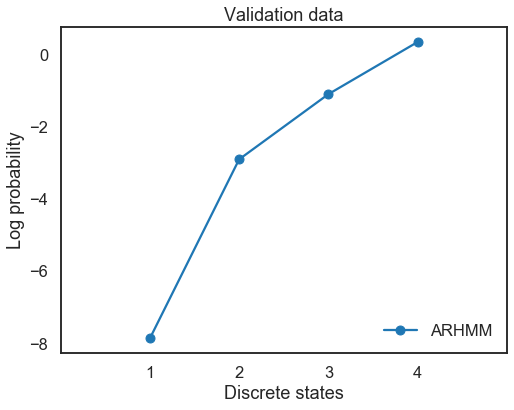

In [12]:
fig = plotting.plot_validation_likelihoods(
    all_results=all_results, 
    T_val=np.sum([d.shape[0] for d in dlc['val']]))
plt.legend(loc='lower right', frameon=False)

In [13]:
model_name = 'arhmm'
K = 4
arhmm = all_results[model_name][K]['model']

# get most likely states
states_all = arhmm.most_likely_states(data_dlc)
# get probability of states
states_prob = arhmm.expected_states(data_dlc)

In [1]:
slc = (0, 1000)
fig = plotting.plot_dlc_arhmm_states(
    dlc_labels=beh, states=states_all, state_probs=states_prob[0], slc=slc)

NameError: name 'plotting' is not defined

# 3. Probe learned dynamics

### find multiple snippets of validation data for each state

In [19]:
model_name = 'arhmm'
K = 4
arhmm = all_results[model_name][K]['model']

# get most likely states
states_all = arhmm.most_likely_states(data_dlc)

# collect all state snippets
length_min = 20  # for collecting state snippets
state_snippets = [{'x': [], 'y': []} for _ in range(K)]
state_lengths = [[] for _ in range(K)]

dtype = 'val'
for indxs_ in indxs[dtype]:
    beg_indx = 0
    curr_state = states_all[indxs_[beg_indx]]
    curr_len = 1
    for curr_indx in range(1, len(indxs_)):
        next_state = states_all[indxs_[curr_indx]]
        if next_state != curr_state:
            # get dlc labels if state duration long enough
            if curr_len >= length_min:
                for coord in ['x', 'y']:
                    state_snippets[curr_state][coord].append(
                        beh[coord][indxs_[beg_indx]:indxs_[curr_indx]])
            # record state length
            state_lengths[curr_state].append(curr_len)
            beg_indx = curr_indx
            curr_state = next_state
            curr_len = 1
        else:
            curr_len += 1
    # end of trial cleanup
    if next_state == curr_state:
        # get dlc labels if state duration long enough
        if curr_len >= length_min:
            for coord in ['x', 'y']:
                state_snippets[curr_state][coord].append(
                    beh[coord][indxs_[beg_indx]:indxs_[curr_indx]])
        # record state length
        state_lengths[curr_state].append(curr_len)
        

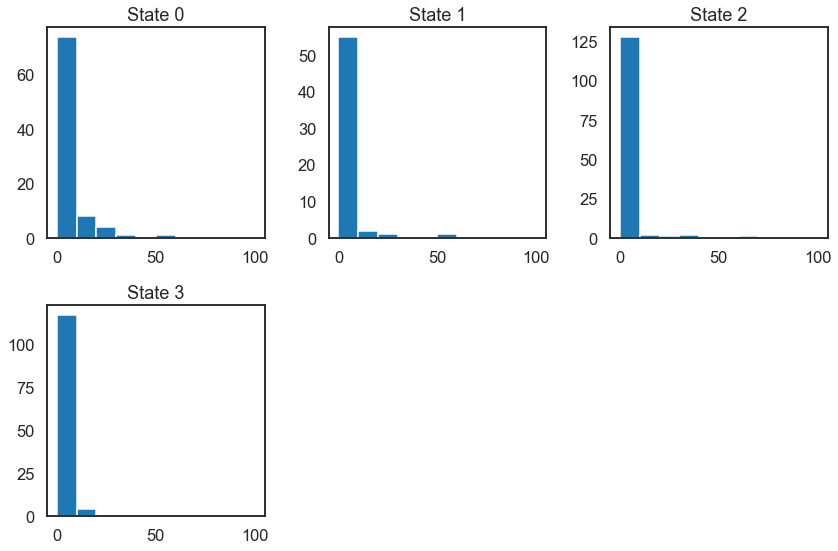

In [20]:
# plot distribution of state durations
n_cols = 3
n_rows = np.ceil(K / n_cols)

fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, slens in enumerate(state_lengths):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(slens, range=(0, 100))
    plt.title(str('State %i' % i))
plt.tight_layout()
plt.show()

In [21]:
print([len(d['x']) for d in state_snippets])

[6, 2, 4, 1]


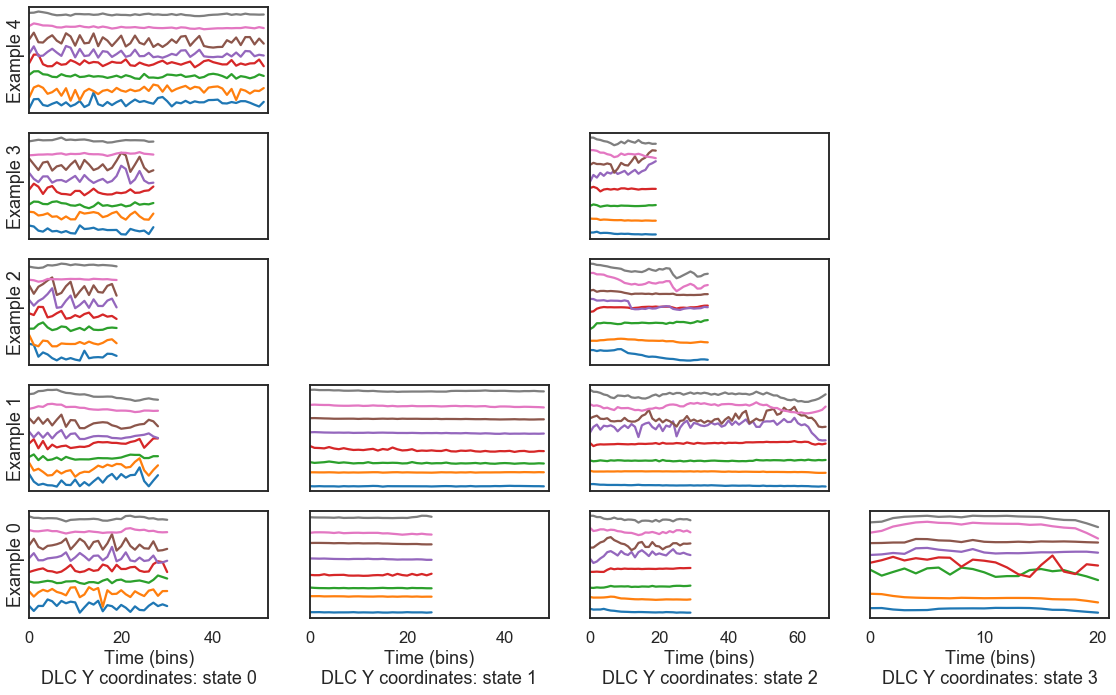

In [31]:
# plot snippets for a single state
states = [0, 1, 2, 3]
max_snippets = 5
n_snippets = [np.min([len(state_snippets[state]['x']), max_snippets]) for state in states]

fig, axes = plt.subplots(
    max(n_snippets), len(states), figsize=(4 * len(states), 2 * max(n_snippets)))
if len(axes.shape) == 1:
    axes = axes[None, :]
for ax1 in axes:
    for ax2 in ax1:
        ax2.set_axis_off()

# get max length on time axis
max_t = 100
n_ts = [
    np.min([max_t, np.max([len(s) for s in state_snippets[state]['x'][:n_snippets[state]]])])
    for state in range(len(states))]

coord = 'y'
for i, k in enumerate(states):
    for j in range(n_snippets[i]):
        behavior = 4 * state_snippets[k][coord][j] / \
            np.max(np.abs(beh[coord])) + np.arange(beh[coord].shape[1])
        
        ax = axes[max(n_snippets)-j-1, i]
        ax.set_axis_on()
        ax.plot(behavior)
        ax.set_xlim([0, n_ts[i]])
        ax.set_yticks([])
        if ax.is_first_col():
            ax.set_ylabel('Example %i' % j)
#         if ax.is_first_row():
#             ax.set_title('DLC %s coordinates: state %i' % (coord.upper(), k))
        if not ax.is_last_row():
            ax.set_xticks([])
        if ax.is_last_row():
            ax.set_xlabel('Time (bins)')
            ax.set_xlabel(
                'Time (bins)\nDLC %s coordinates: state %i' % (coord.upper(), k))
            
#         axes[0, i].set_title('DLC %s coordinates: state %i' % (coord.upper(), k))
plt.tight_layout()
plt.show()